# Continuous Control

---

In this notebook, you will learn how to train an agent to solve the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import progressbar as pb
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. 
A **reward** of **+0.1** is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The **observation space** consists of **33 variables** corresponding to **position, rotation, velocity, and angular velocities of the arm**. 

Each **action** is a vector with **four numbers**, corresponding to torque applicable to two joints. Every **entry** in the action vector should be a number between **-1 and 1**.


Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. It's Your Turn!

Your agents must get an average score of +30 (over 100 consecutive episodes, and over all agents). Specifically,

* After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 20 (potentially different) scores. We then take the average of these 20 scores.
* This yields an **average score** for each episode (where the average is over all 20 agents).

The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30.

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:

```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# Creat an instance of the agent to be trained
ddpg = Agent(state_size=state_size,
             action_size=action_size,
             random_seed=1234,
             hidden_layers=[64,128],
             n_agents=num_agents
            )

# Training process
def train_agent(agent, n_episodes=10000, max_it=1000):
    """ Train an agent using Deep Determinstic Policy Gradient learning
    
    Params
    ======
        agent (Agent): an agent that interacts with and learns from the environment.
        n_episodes (int): maximum number of training episodes
        max_it (int): maximum number of iteration per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    widget = [pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
 
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        score = np.zeros(agent.n_agents)
        agent.reset()
        states = env_info.vector_observations                  # get the current states
        for t in range(max_it):
            actions = agent.act(states)                        # compute actions for each agent  
            env_info = env.step(actions)[brain_name]           # send the action to the environment
            next_states = env_info.vector_observations         # get next states
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        scores_window.append(np.mean(score))       # save the average over all the agents in the last episode
        scores.append(np.mean(score))              # save the average over all the agents in the last episode  
        
        #if i_episode % 10 == 0:    
        timer.update(i_episode)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    timer.finish()
    return scores

def show_agent_performance(scores):
    """ Show the score of obtained by an agent during his training phase"""
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Train a Deep Deterministic Policy Gradient Agent

In [6]:
import time
begin = time.time()
scores_ddpg = train_agent(ddpg)
print(time.time()-begin)

Episode 1	Average Score: 0.27

Episode 2	Average Score: 0.61

Episode 3	Average Score: 0.67

Episode 4	Average Score: 0.72

Episode 5	Average Score: 0.72

Episode 6	Average Score: 0.81

Episode 7	Average Score: 0.93

Episode 8	Average Score: 1.04

Episode 9	Average Score: 1.14

Episode 10	Average Score: 1.14

Episode 11	Average Score: 1.07

Episode 12	Average Score: 1.20

Episode 13	Average Score: 1.34

Episode 14	Average Score: 1.40

Episode 15	Average Score: 1.50

Episode 16	Average Score: 1.57

Episode 17	Average Score: 1.67

Episode 18	Average Score: 1.84

Episode 19	Average Score: 2.09

Episode 20	Average Score: 2.28

Episode 21	Average Score: 2.51

Episode 22	Average Score: 2.73

Episode 23	Average Score: 2.99

Episode 24	Average Score: 3.26

Episode 25	Average Score: 3.51

Episode 26	Average Score: 3.81

Episode 27	Average Score: 4.13

Episode 28	Average Score: 4.43

Episode 29	Average Score: 4.88

Episode 30	Average Score: 5.33

Episode 31	Average Score: 5.80

Episode 32	Average Score: 6.31

Episode 33	Average Score: 6.98

Episode 34	Average Score: 7.65

Episode 35	Average Score: 8.31

Episode 36	Average Score: 8.95

Episode 37	Average Score: 9.56

Episode 38	Average Score: 10.18

Episode 39	Average Score: 10.79

Episode 40	Average Score: 11.39

Episode 41	Average Score: 11.98

Episode 42	Average Score: 12.56

Episode 43	Average Score: 13.09

Episode 44	Average Score: 13.61

Episode 45	Average Score: 14.12

Episode 46	Average Score: 14.61

Episode 47	Average Score: 15.10

Episode 48	Average Score: 15.56

Episode 49	Average Score: 15.99

Episode 50	Average Score: 16.41

Episode 51	Average Score: 16.81

Episode 52	Average Score: 17.20

Episode 53	Average Score: 17.57

Episode 54	Average Score: 17.93

Episode 55	Average Score: 18.26

Episode 56	Average Score: 18.57

Episode 57	Average Score: 18.87

Episode 58	Average Score: 19.17

Episode 59	Average Score: 19.45

Episode 60	Average Score: 19.74

Episode 61	Average Score: 20.00

Episode 62	Average Score: 20.26

Episode 63	Average Score: 20.51

Episode 64	Average Score: 20.75

Episode 65	Average Score: 20.99

Episode 66	Average Score: 21.23

Episode 67	Average Score: 21.46

Episode 68	Average Score: 21.67

Episode 69	Average Score: 21.89

Episode 70	Average Score: 22.10

Episode 71	Average Score: 22.30

Episode 72	Average Score: 22.50

Episode 73	Average Score: 22.69

Episode 74	Average Score: 22.88

Episode 75	Average Score: 23.07

Episode 76	Average Score: 23.24

Episode 77	Average Score: 23.41

Episode 78	Average Score: 23.57

Episode 79	Average Score: 23.73

Episode 80	Average Score: 23.87

Episode 81	Average Score: 24.01

Episode 82	Average Score: 24.15

Episode 83	Average Score: 24.27

Episode 84	Average Score: 24.39

Episode 85	Average Score: 24.49

Episode 86	Average Score: 24.60

Episode 87	Average Score: 24.74

Episode 88	Average Score: 24.86

Episode 89	Average Score: 24.99

Episode 90	Average Score: 25.09

Episode 91	Average Score: 25.21

Episode 92	Average Score: 25.33

Episode 93	Average Score: 25.43

Episode 94	Average Score: 25.55

Episode 95	Average Score: 25.67

Episode 96	Average Score: 25.77

Episode 97	Average Score: 25.87

Episode 98	Average Score: 25.98

Episode 99	Average Score: 26.08

Episode 100	Average Score: 26.17


Episode 101	Average Score: 26.54

Episode 102	Average Score: 26.88

Episode 103	Average Score: 27.23

Episode 104	Average Score: 27.58

Episode 105	Average Score: 27.93

Episode 106	Average Score: 28.27

Episode 107	Average Score: 28.62

Episode 108	Average Score: 28.96

Episode 109	Average Score: 29.31

Episode 110	Average Score: 29.67

Episode 111	Average Score: 30.02
Environment solved in 11 episodes!	Average Score: 30.02
1191.9998977184296


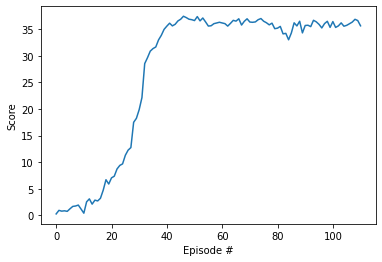

In [7]:
show_agent_performance(scores_ddpg)

### 5. Saving the model

In [8]:
# Save DDPG model
checkpoint = {'state_size': state_size,
              'action_size': action_size,
              'hidden_layers':[64,128],
              'seed':1234,
              'n_agents':num_agents,
              'scores':scores_ddpg,
              'al_state_dict': ddpg.actor_local.state_dict(),
              'at_state_dict': ddpg.actor_target.state_dict(),
              'cl_state_dict': ddpg.critic_local.state_dict(),
              'ct_state_dict': ddpg.critic_target.state_dict(),            
             }

torch.save(checkpoint, './saved_models/ddpg_model.pth')

When finished, you can close the environment.

In [11]:
env.close()